In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#### Zu den Daten
Die Auswertung der Flugpassagiere nach Destination ist beim BfS auf Anfrage erhältlich. Aktuell ist der Zeitraum 2018 bis Q3 2021 verfügbar.

Im Excel (wmove_wvs_2018_2021__kunde.xlsx) enthalten sind fünf Tabellenblätter:
* flughäfen: Übersicht über die verwendeten Abkürzungen
* wmove: Etappenziel nach Land
* wmove1: Etappenziel nach Land und Flughafen
* wvs: Endziel nach Land
* wvs1: Endziel nach Land und Flughafen

*Art der Passagiere*
* Passagiere bei wvs und wvs1: Nach Auskunft BfS nur Lokalpassagiere, keine Umsteigepassagiere
* Passagiere bei wmove und wmove1: Nach Auskunft BfS Lokal- und Umsteigepassagiere
* Transitpassagiere: Passagiere, die nach einer Zwischenlandung im gleichen Flugzeug weiterfliegen (kein eigentliches Umsteigen).

Nach Auskunft des BfS sind bei den Angaben zum Endziel der Reise nur Lokalpassagiere enthalten. Konkret: Wer fliegt von der Schweiz aus wohin (allenfalls nach einem Umsteigen am ersten Flughafen nach Zürich). Bei den Etappenzielen sind alle Passagiere drin, auch wenn sie z.B. von Österreich nach Zürich und dann weitergeflogen sind. Zudem ist überall einfach der nächste Flughafen erfasst, nicht der letzte Flughafen der Reise. Das heisst: Wer von Wien über Zürich nach London fliegt, ist mit Zürich-London erfasst. Genauso mit Zürich-London erfasst ist ein Passagier, der Zürich-London-San Francisco fliegt. Weil die Angaben zum Etappenziel vollständiger sind, arbeiten wir mit diesem.

### 1. Schritt: Daten einlesen

In [2]:
#Zwei relevante Tabellenblätter einlesen
xls = pd.ExcelFile('wmove_wvs_2018_2021__kunde.xlsx')
etappe = pd.read_excel(xls, 'wmove1', skiprows=3) #Etappenziel: Erster Flughafen nach Abflug aus ZRH

Im Dataframe sind Abflüge von allen Schweizer Flughäfen enthalten. Uns interessieren jene ab Zürich. Wir filtern nach diesen und bereinigen die Daten.

In [3]:
#Filtern nach Abflügen aus Zürich (=LSZH) und die Spalte dann entfernen
etappe = etappe[etappe['Flughafen'] == 'LSZH']
etappe.drop('Flughafen',axis=1,inplace=True)

In [4]:
#Jahr und Monat sind in unterschiedlichen Spalten erfasst, die wir zusammenführen
etappe['Datum'] = etappe['Jahr'].astype(str) + '-' + etappe['Monat'].astype(str)

In [5]:
#Die Spalten Monat und Jahr brauchen wir nun nicht mehr separat
etappe.drop(['Monat','Jahr'], axis=1, inplace=True)

In [6]:
#Die Datumsspalte ist noch nicht als solche formatiert. Das ändern wir
etappe['Datum'] =  pd.to_datetime(etappe['Datum'], format='%Y-%m')

In [7]:
#Im Dataframe sind Passagiere und Transitpassagiere getrennt. Wir rechnen sie zusammen.
etappe['Passagiere'] = etappe['Passagiere'] + etappe['Transitpassagiere']
etappe.drop('Transitpassagiere', axis=1, inplace=True)

In [8]:
#Wir pivotieren das Dataframe und trennen dabei gleich Flüge und Passagiere.
etappe_pax = etappe.pivot(index='Datum', columns=['Ort/Flughafen'], values='Passagiere')
etappe_flights = etappe.pivot(index='Datum', columns=['Ort/Flughafen'], values='Flüge')

In [9]:
#In der weiteren Betrachtung hat sich gezeigt, dass Istanbul zweifach erfasst ist. Die beiden Spalten verschmelzen wir.
etappe_pax["Istanbul"] = etappe_pax.fillna(0)["Istanbul"] + etappe_pax.fillna(0)["Istanbul Sabiha Gokcen"]
etappe_pax.drop("Istanbul Sabiha Gokcen", axis=1, inplace=True)

In [10]:
#Zum Vergleich der Bedeutung eines Zielflughafens sind relative Angaben sinnvoller.
etappe_pax_rel = etappe_pax.div(etappe_pax.sum(axis=1), axis=0) * 100

### 2.Schritt: Daten auswerten

In [11]:
#NaN zu 0 machen
etappe_pax = etappe_pax.fillna(0)
etappe_pax_rel = etappe_pax_rel.fillna(0)

In [12]:
#Für eine Netzwerkgrafik extrahieren wir jene Destinationen, die in mindestens einem Monat zu den Top Ten/Top Five ab ZRH angeflogenen Destinationen gehörten.
etappe_pax_rank = etappe_pax.rank(axis=1, ascending=False, method="min").sort_values(by="2021-09-01", axis=1)
etappe_pax_rank.columns[(etappe_pax_rank<10).any()]

Index(['London', 'Palma De Mallorca', 'Berlin', 'Amsterdam', 'Wien', 'Madrid',
       'Istanbul', 'Hamburg', 'Barcelona', 'Athen', 'Antalya', 'New York',
       'Frankfurt', 'Lisboa', 'Porto', 'Malaga', 'Beograd', 'Dubai', 'Paris',
       'Düsseldorf', 'Heraklion', 'Genève', 'Stockholm', 'Roma', 'Warszawa',
       'Pristina (Kosovo)', 'Hurghada', 'Sao Paulo',
       'Skopje Alexander the Great', 'Ankara'],
      dtype='object', name='Ort/Flughafen')

In [13]:
etappe_pax_rank.columns[(etappe_pax_rank<5).any()]

Index(['London', 'Palma De Mallorca', 'Berlin', 'Amsterdam', 'Wien', 'Madrid',
       'Istanbul', 'Hamburg', 'Antalya', 'Frankfurt', 'Porto', 'Beograd',
       'Dubai', 'Paris', 'Düsseldorf', 'Stockholm', 'Pristina (Kosovo)'],
      dtype='object', name='Ort/Flughafen')

In [14]:
etappe_pax[etappe_pax_rank.columns[(etappe_pax_rank<10).any()]].to_excel("top10-destinationen.xlsx") #Alle Monate dieser Destinationen
etappe_pax[etappe_pax_rank.columns[(etappe_pax_rank<5).any()]].to_excel("top5-destinationen.xlsx") #Alle Monate dieser Destinationen

In [38]:
#Für kleinere Datenmenge mit einem Jahr vor und zwei Jahren während Corona
#Der jeweilige Schnitt von neun Monaten ermöglicht uns, jeweils im September den Schnitt des bisherigen Jahres zu eruieren (im letzten Jahr haben wir nur Daten bis in den September)
etappe_pax_mean = etappe_pax.rolling(9).mean()
etappe_pax_firstnine = etappe_pax_mean.iloc[[20,32,44],:]
etappe_pax_firstnine[etappe_pax_rank.columns[(etappe_pax_rank<10).any()]].to_excel("top10-destinationen-janbissep.xlsx")
etappe_pax_firstnine[etappe_pax_rank.columns[(etappe_pax_rank<5).any()]].to_excel("top5-destinationen-janbissep.xlsx")

Hier extrahieren wir die bedeutendsten Flughäfen, also jene Flughäfen, die von Zürich aus relativ am meisten angeflogen werden.

In [16]:
#Die drei bedeutendsten Zielflughäfen pro Monat in ein Dataframe dftop schreiben.
dftop = pd.DataFrame(etappe_pax_rel.columns.values[np.argsort(-etappe_pax_rel.values, axis=1)[:, :3]],
                  index=etappe_pax_rel.index,
                  columns = ['1st Max','2nd Max','3rd Max']).reset_index()
dftop

,Datum,1st Max,2nd Max,3rd Max
0,2018-01-01,London,Amsterdam,Berlin
1,2018-02-01,London,Berlin,Amsterdam
2,2018-03-01,London,Berlin,Amsterdam
3,2018-04-01,London,Berlin,Wien
4,2018-05-01,London,Berlin,Wien
5,2018-06-01,London,Berlin,Wien
6,2018-07-01,London,Berlin,Wien
7,2018-08-01,London,Berlin,Amsterdam
8,2018-09-01,London,Berlin,Wien
9,2018-10-01,London,Berlin,Amsterdam


Nun schauen wir uns Veränderungen zum Vorjahr/Vormonat konkreter an.

In [17]:
#Die prozentuale Veränderung der Passagiere pro angeflogenem Flughafen berechnen wir von Jahr zu Jahr (etappe_pax_vorjahr) und von Monat zu Monat (etappe_pax_vormonat) mit pct_change.
etappe_pax_vorjahr = etappe_pax.pct_change(12)
etappe_pax_vormonat = etappe_pax.pct_change(1)

In [18]:
#Die prozentuale Veränderung der Bedeutung pro angeflogenem Flughafen berechnen wir von Jahr zu Jahr (etappe_pax_rel_vorjahr) und von Monat zu Monat (etappe_pax_rel_vormonat) mit einer einfachen Subtraktion (Unterschied = Prozentpunkte)
etappe_pax_rel_vorjahr = etappe_pax_rel.diff(12)
etappe_pax_rel_vormonat = etappe_pax_rel.diff(1)

Nun schauen wir uns die Veränderungen zu vor der Pandemie an.

In [19]:
#Wir erstellen je zwei Dataframes: Eines mit den 2019er-Zahlen, eines mit denen danach
etappe_pax_2019 = etappe_pax.iloc[12:24,:].copy()
etappe_pax_pandemie = etappe_pax.iloc[24:,:].copy()
etappe_pax_rel_2019 = etappe_pax_rel.iloc[12:24,:].copy()
etappe_pax_rel_pandemie = etappe_pax_rel.iloc[24:,:].copy()

In [20]:
#Um eine Differenz zwischen zwei Dataframes berechnen zu können, die potenziell unterschiedlich lang sind, brauchen wir eine Code-Zeile, die auf einer Spalte mit der Monatsangabe als String basiert. Diese müssen wir zuerst erstellen.
#Einmal für die absoluten Zahlen
etappe_pax_pandemie['index'] = etappe_pax_pandemie.index
etappe_pax_2019['index'] = etappe_pax_2019.index
etappe_pax_pandemie['index'] = etappe_pax_pandemie['index'].dt.strftime('%Y-%m-%d')
etappe_pax_2019['index'] = etappe_pax_2019['index'].dt.strftime('%Y-%m-%d')
#Einmal für die relativen Zahlen
etappe_pax_rel_pandemie['index'] = etappe_pax_rel_pandemie.index
etappe_pax_rel_2019['index'] = etappe_pax_rel_2019.index
etappe_pax_rel_pandemie['index'] = etappe_pax_rel_pandemie['index'].dt.strftime('%Y-%m-%d')
etappe_pax_rel_2019['index'] = etappe_pax_rel_2019['index'].dt.strftime('%Y-%m-%d')

In [21]:
#Wir berechnen den Unterschied in jeder Spalte mit dem folgenden for-Loop (Erklärung für die Zeile im for-Loop nachfolgend ausführlich)
#Einmal für die absoluten Zahlen (Resultat sind logischerweise auch absolute Zahlen)
diff = []
for column in etappe_pax_pandemie.iloc[: , :-1]:
    diff.append(etappe_pax_pandemie[column].sub(etappe_pax_pandemie['index'].str.split('-').str[-2].map(dict(zip(etappe_pax_2019['index'].str.split('-').str[-2], etappe_pax_2019[column])))))
#Einmal für die relativen Zahlen (Resultat sind ProzentPUNKTE)
diffrel = []
for column in etappe_pax_pandemie.iloc[: , :-1]:
    diffrel.append(etappe_pax_rel_pandemie[column].sub(etappe_pax_rel_pandemie['index'].str.split('-').str[-2].map(dict(zip(etappe_pax_rel_2019['index'].str.split('-').str[-2], etappe_pax_rel_2019[column])))))

Die Erklärung dieser Codezeile:
* Im ersten Teil des Teils nach .sub (zum Teil davor weiter unten) (bis vor .map) nehmen wir den Monat des Pandemie-Dfs.
* Auf diesen Teil wenden wir später .map an.
* In der Klammer nach .map wird ein Dictionary erzeugt mit dem Monat des 2019-Dataframes und dem entsprechenden Wert des Monats im gleichen Dataframe.
* Der Key dieses Dictionarys ist dann jeweils der Monat. 
* .map nimmt nun den Monat vom ersten Teil (also vom Pandemie-Dataframe) und sucht den korrekten Key vom Dictionary (also den Monat vom 2019-Dataframe) und gibt den Wert davon aus.
* In der Klammer nach .sub steht also am Ende ein Wert, der vom Wert vom Teil vor .sub abgezogen wird. Vor .sub steht das Pandemie-Dataframe. Es ergibt sich also am Schluss: Monatswert im Pandemie-Dataframe minus Monatswert im 2019er-Dataframe gleich Differenz vom Monat ab 2020 zum gleichen Monat im Jahr 2019.

In [22]:
#Daraus erstellen wir nun Dataframes
etappe_pax_unterschied = pd.DataFrame(diff)
etappe_pax_unterschied = etappe_pax_unterschied.T
etappe_pax_rel_unterschied = pd.DataFrame(diffrel)
etappe_pax_rel_unterschied = etappe_pax_rel_unterschied.T

In [23]:
#Diesen Dataframes fehlt noch der richtige Header. Der ist identisch mit den Dataframes vor der Berechnung des Unterschieds (ohne die letzte Spalte 'index').
etappe_pax_unterschied.columns = etappe_pax_pandemie.columns[:-1]
etappe_pax_rel_unterschied.columns = etappe_pax_pandemie.columns[:-1]

In [24]:
#Grösste Rückgänge in absoluten Zahlen pro Monat
loser_names = etappe_pax_unterschied.idxmin(axis=1)
loser_values = etappe_pax_unterschied.min(axis=1)
loser = pd.DataFrame(loser_names)
loser['Values'] = loser_values
loser

,0,Values
Datum,,
2020-01-01,Düsseldorf,-4258.0
2020-02-01,Hong Kong,-5671.0
2020-03-01,London,-50133.0
2020-04-01,London,-86649.0
2020-05-01,London,-74159.0
2020-06-01,London,-79320.0
2020-07-01,London,-80818.0
2020-08-01,London,-64805.0
2020-09-01,London,-77038.0


In [25]:
#Die drei grössten Verlierer pro Monat
minima = []
for column in etappe_pax_unterschied.T:
    min3 = etappe_pax_unterschied.T.nsmallest(3, columns=column)
    minima.append(min3[column])
loser3 = pd.DataFrame(minima)
loser3

Ort/Flughafen,Düsseldorf,Hamburg,Incheon International,Hong Kong,Shanghai Pudong International,London,Berlin,Wien,Amsterdam,New York,Barcelona,Palma De Mallorca
2020-01-01,-4258.0,-3379.0,-3132.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-01,-3636.0,NaN,NaN,-5671.0,-4538.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-01,-26756.0,NaN,NaN,NaN,NaN,-50133.0,-35106.0,NaN,NaN,NaN,NaN,NaN
2020-04-01,NaN,NaN,NaN,NaN,NaN,-86649.0,-51784.0,-44962.0,NaN,NaN,NaN,NaN
2020-05-01,NaN,NaN,NaN,NaN,NaN,-74159.0,-49329.0,-44679.0,NaN,NaN,NaN,NaN
2020-06-01,NaN,NaN,NaN,NaN,NaN,-79320.0,-42829.0,NaN,-38956.0,NaN,NaN,NaN
2020-07-01,NaN,NaN,NaN,NaN,NaN,-80818.0,NaN,NaN,-33623.0,-33383.0,NaN,NaN
2020-08-01,NaN,NaN,NaN,NaN,NaN,-64805.0,NaN,NaN,NaN,-31732.0,-30562.0,NaN
2020-09-01,NaN,NaN,NaN,NaN,NaN,-77038.0,NaN,NaN,NaN,NaN,-32129.0,-32196.0
2020-10-01,NaN,NaN,NaN,NaN,NaN,-79492.0,-38566.0,NaN,-37364.0,NaN,NaN,NaN


In [26]:
#Grösste Gewinne in absoluten Zahlen pro Monat
winner_names = etappe_pax_unterschied.idxmax(axis=1)
winner_values = etappe_pax_unterschied.max(axis=1)
winner = pd.DataFrame(winner_names)
winner['Values'] = winner_values
winner

,0,Values
Datum,,
2020-01-01,London,2794.0
2020-02-01,Madrid,3211.0
2020-03-01,Kansai International,996.0
2020-04-01,Ankara,326.0
2020-05-01,Kishinev,98.0
2020-06-01,Menorca,139.0
2020-07-01,Porto,618.0
2020-08-01,Mikonos,628.0
2020-09-01,Brindisi,1171.0


In [27]:
#Die drei grössten Gewinner pro Monat
maxima = []
for column in etappe_pax_unterschied.T:
    max3 = etappe_pax_unterschied.T.nlargest(3, columns=column)
    maxima.append(max3[column])
winner3 = pd.DataFrame(maxima)
winner3

Ort/Flughafen,London,Paris,Madrid,Miami,Kobenhavn,Kansai International,Lima,Bogota,Ankara,Sydney,...,Santiago,Ibiza,Yerevan,Dallas/Fort Worth,Santa Cruz De La Palma,Sarajevo,Heraklion,Istanbul,Basel Mühlhausen,Tallinn
2020-01-01,2794.0,2622.0,1825.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-01,NaN,NaN,3211.0,3028.0,2542.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-01,NaN,NaN,NaN,NaN,NaN,996.0,34.0,32.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,326.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
#Grösste Rückgänge in relativen Zahlen pro Monat
loser_rel_names = etappe_pax_rel_unterschied.idxmin(axis=1)
loser_rel_values = etappe_pax_rel_unterschied.min(axis=1)
loser_rel = pd.DataFrame(loser_rel_names)
loser_rel['Values'] = loser_rel_values
loser_rel

,0,Values
Datum,,
2020-01-01,Düsseldorf,-0.441278
2020-02-01,Hong Kong,-0.551932
2020-03-01,Düsseldorf,-0.814829
2020-04-01,Wien,-3.236916
2020-05-01,Wien,-3.354209
2020-06-01,London,-2.957656
2020-07-01,London,-2.747842
2020-08-01,Barcelona,-1.499854
2020-09-01,London,-2.727445


In [29]:
#Die drei grössten Verlierer pro Monat
minima_rel = []
for column in etappe_pax_rel_unterschied.T:
    min3_rel = etappe_pax_rel_unterschied.T.nsmallest(3, columns=column)
    minima_rel.append(min3_rel[column])
loser_rel3 = pd.DataFrame(minima_rel)
loser_rel3

Ort/Flughafen,Düsseldorf,Hamburg,Incheon International,Hong Kong,Shanghai Pudong International,Tel Aviv,Venice,Wien,Madrid,Genève,Paris,London,New York,Dubai,Barcelona,Singapore,Palma De Mallorca,Berlin,SUVARNABHUMI BANGKOK INTERNATIONAL
2020-01-01,-0.441278,-0.35048,-0.308649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-01,-0.332557,NaN,NaN,-0.551932,-0.449614,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-01,-0.814829,NaN,NaN,NaN,NaN,-0.806324,-0.680094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.236916,-2.181006,-1.919602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.354209,-2.199128,NaN,-2.388238,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.885106,-1.346329,-2.957656,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.747842,-1.633732,-1.46901,NaN,NaN,NaN,NaN,NaN
2020-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.486329,NaN,-1.499854,-1.432447,NaN,NaN,NaN
2020-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.727445,NaN,NaN,-1.927492,NaN,-1.948075,NaN,NaN
2020-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.869942,-3.817885,-1.640094,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
#Grösste Gewinne in relativen Zahlen pro Monat
winner_rel_names = etappe_pax_rel_unterschied.idxmax(axis=1)
winner_rel_values = etappe_pax_rel_unterschied.max(axis=1)
winner_rel = pd.DataFrame(winner_rel_names)
winner_rel['Values'] = winner_rel_values
winner_rel

,0,Values
Datum,,
2020-01-01,Paris,0.234747
2020-02-01,Madrid,0.349542
2020-03-01,London,0.981308
2020-04-01,Frankfurt,16.729253
2020-05-01,Frankfurt,17.523339
2020-06-01,Beograd,5.832943
2020-07-01,Porto,3.185892
2020-08-01,Berlin,2.879934
2020-09-01,Berlin,3.549278


In [31]:
#Die drei grössten Gewinner pro Monat
maxima_rel = []
for column in etappe_pax_rel_unterschied.T:
    max3_rel = etappe_pax_rel_unterschied.T.nlargest(3, columns=column)
    maxima_rel.append(max3_rel[column])
winner_rel3 = pd.DataFrame(maxima_rel)
winner_rel3

Ort/Flughafen,Paris,London,Stockholm,Madrid,Miami,Kobenhavn,Frankfurt,Amsterdam,Porto,Beograd,Palma De Mallorca,Berlin,Hamburg,Antalya,Pristina (Kosovo),Istanbul,Sao Paulo,Dubai,Heraklion
2020-01-01,0.234747,0.210226,0.162535,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-01,NaN,NaN,NaN,0.349542,0.316538,0.272909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-01,NaN,0.981308,NaN,NaN,NaN,NaN,0.808602,0.716176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-01,NaN,NaN,NaN,NaN,NaN,NaN,16.729253,8.295033,5.109032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-01,NaN,NaN,NaN,NaN,NaN,NaN,17.523339,6.948094,10.041783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-01,NaN,NaN,NaN,NaN,NaN,NaN,4.264390,NaN,3.720189,5.832943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.185892,NaN,2.011242,1.975730,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.727759,NaN,NaN,2.879934,2.332036,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.002771,NaN,3.549278,NaN,2.827470,NaN,NaN,NaN,NaN,NaN
2020-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.859432,NaN,NaN,NaN,5.553496,6.794676,NaN,NaN,NaN,NaN


Rückgänge und Gewinne lassen sich anhand einzelner Flughäfen gut aufzeigen. Wir nehmen hier die absoluten Passagierzahlen (keine Veränderungen oder relative Zahlen) von London und Berlin sowie Pristina und Palma De Mallorca, die alle oben herausgestochen sind.

In [37]:
entwicklung = pd.concat([etappe_pax.filter(like="London"),etappe_pax.filter(like='Berlin'),etappe_pax.filter(like='Pristina'),etappe_pax.filter(like='Palma De Mallorca'),etappe_pax.filter(like="Istanbul")], axis=1)
columns = ["London","Berlin","Pristina","Palma De Mallorca","Istanbul"]
entwicklung.columns = columns
entwicklung.to_csv('Entwicklung_ausgewählte_Destinationen.csv')

<AxesSubplot:xlabel='Datum'>

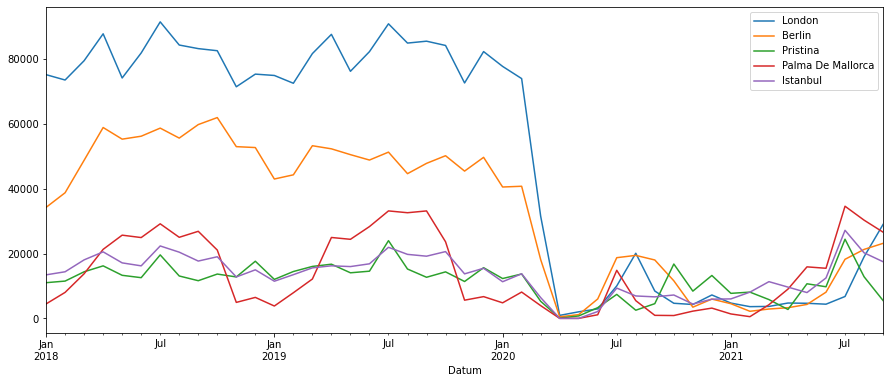

In [33]:
entwicklung.plot(figsize=(15,6))

<AxesSubplot:xlabel='Datum'>

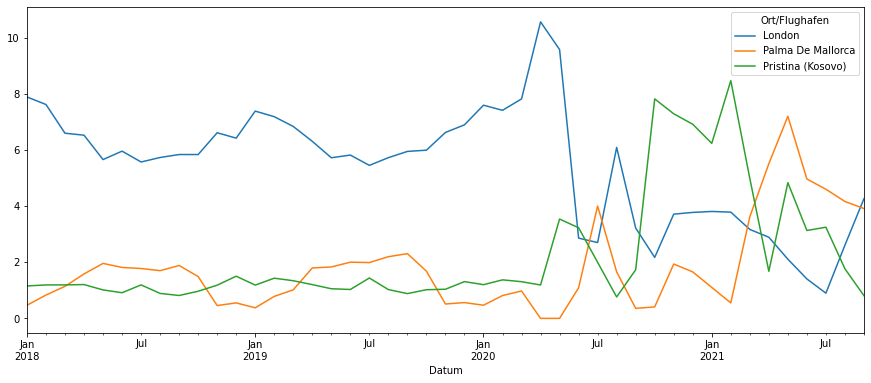

In [34]:
#Wir können auch die relative Bedeutung dieser Flughäfen betrachten
etappe_pax_rel[['London','Palma De Mallorca','Pristina (Kosovo)']].plot(figsize=(15,6))

In [35]:
etappe_pax_rel[['London','Palma De Mallorca','Pristina (Kosovo)']]

Ort/Flughafen,London,Palma De Mallorca,Pristina (Kosovo)
Datum,,,
2018-01-01,7.884854,0.467549,1.154603
2018-02-01,7.615960,0.830352,1.191383
2018-03-01,6.593504,1.141587,1.192210
2018-04-01,6.523748,1.582443,1.203932
2018-05-01,5.654953,1.957540,1.013102
2018-06-01,5.955305,1.813224,0.913234
2018-07-01,5.568919,1.775963,1.192178
2018-08-01,5.729266,1.699345,0.888453
2018-09-01,5.834615,1.883118,0.814767


## Modifikationen für durchsuchbare Flourish-Tabelle

In [36]:
#Grundlage ist das Dataframe etappe_pax. Die Angaben pro Monat werden für eine Mini Line-Chart auch verwendet. Für die Tabelle wären das aber zu viele Werte.
flourish = etappe_pax.T
flourish['April19'] = etappe_pax.T['2019-04-01']
flourish['April20'] = etappe_pax.T['2020-04-01']
flourish['April21'] = etappe_pax.T['2021-04-01']
flourish.astype(int).to_csv("Passagiere pro Destination.csv")